In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb, plot_session_glm
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
from matplotlib import cm
import matplotlib.colors as mcolors
from joblib import Parallel, delayed
from utils.combine_tools import apply_qc
%matplotlib inline


In [2]:
beh_combined_file = '/root/capsule/scratch/combined/combined_session_tbl/combined_beh_sessions.pkl'
with open(beh_combined_file, 'rb') as f:
    beh_combined = pickle.load(f)

In [57]:
# regression model, use past rewards/no reward,  to predict future go/no-go
def hit_glm(session):
    session_tbl = get_session_tbl(session)

    t_Max = 3
    t_Max_hist = 0

    hit = session_tbl['animal_response'].values != 2
    rewards = (session_tbl['rewarded_historyL'].values == 1) | (session_tbl['rewarded_historyR'].values == 1)
    rewards[~hit] = np.nan  # only consider rewards when there is a hit
    choice = session_tbl['animal_response'].values
    pre_choice = np.full(len(choice), np.nan)
    pre_choice[1:] = choice[:-1]
    for i in range(1, len(choice)):
        if pre_choice[i] == 2:  # no-go
            last_choice = np.where(choice[:i] != 2)[0][-1] if np.any(choice[:i] != 2) else 0
            pre_choice[i] = choice[last_choice] if last_choice > 0 else np.nan

    # for each pre_choice == 2, get the lastest choice that is not 2


    hit_mtx = np.full((t_Max_hist, len(hit)), np.nan, dtype=float)
    for i in range(t_Max_hist):
        hit_mtx[i, i+1:] = hit[:(len(hit)-(i+1))]

    rwd_mtx = np.full((t_Max, len(hit)), np.nan, dtype=float)
    for i in range(t_Max):
        rwd_mtx[i, i+1:] = rewards[:(len(hit)-(i+1))]
    col_list = [f'rwd_{i+1}' for i in range(t_Max)]
    pre_hist_list = [f'hit_{i+1}' for i in range(t_Max_hist)]
    col_list.extend(pre_hist_list)
    matrix = np.concatenate((rwd_mtx, hit_mtx), axis=0)
    reg_df = pd.DataFrame(matrix.T, columns=col_list)
    reg_df['hit'] = hit
    # reg_df['pre_choice'] = pre_choice
    # use statsmodels to fit a GLM
    X = reg_df.drop(columns=['hit']).values
    y = reg_df['hit'].values
    X = sm.add_constant(X)  # add intercept term
    # nan mask to filter nan mask
    nan_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[nan_mask]
    y = y[nan_mask]
    model = sm.Logit(y, X)
    result = model.fit()
    # print(result.summary())

    rwd_coeffs = result.params[1:t_Max+1]
    hit_coeffs = result.params[t_Max+1:-1]
    # pre_choice_coeff = result.params[-1]

    # # plot coefficients
    # plt.figure(figsize=(10, 6))
    # plt.bar(range(t_Max), rwd_coeffs, label='Reward Coefficients', alpha=0.7)
    # plt.bar(range(t_Max, t_Max + t_Max_hist + 1), hit_coeffs, label='Hit Coefficients', alpha=0.7)
    # plt.bar(range(t_Max + t_Max_hist + 1, t_Max + t_Max_hist+2), pre_choice_coeff, label='Hit Coefficients', alpha=0.7)
    # plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    # plt.xlabel('Time Lag')
    # plt.ylabel('Coefficient Value')
    # plt.title('GLM Coefficients for Reward and Hit History')
    return {'rwd_coeffs': rwd_coeffs,
            'hit_coeffs': hit_coeffs,
            # 'pre_choice_coeff': pre_choice_coeff,
            'session_id': session}



In [93]:
# regression model, use past rewards/no reward,  to predict future go/no-go
def hit_glm_ani(ani, t_Max = 3, t_Max_hist = 0):

    session_list_file = '/root/capsule/scratch/combined/combined_session_tbl/combined_beh_sessions.pkl'
    with open(session_list_file, 'rb') as f:
        combined_session_tbl = pickle.load(f)
    session_list = combined_session_tbl[combined_session_tbl['ani_id'] == ani]['session_id'].values
    combined_reg_df = pd.DataFrame()
    for session in session_list:
        session_tbl = get_session_tbl(session)

        hit = session_tbl['animal_response'].values != 2
        rewards = (session_tbl['rewarded_historyL'].values == 1) | (session_tbl['rewarded_historyR'].values == 1)
        # rewards[~hit] = np.nan  # only consider rewards when there is a hit
        choice = session_tbl['animal_response'].values
        pre_choice = np.full(len(choice), np.nan)
        pre_choice[1:] = choice[:-1]
        for i in range(1, len(choice)):
            if pre_choice[i] == 2:  # no-go
                last_choice = np.where(choice[:i] != 2)[0][-1] if np.any(choice[:i] != 2) else 0
                pre_choice[i] = choice[last_choice] if last_choice > 0 else np.nan

        hit_mtx = np.full((t_Max_hist, len(hit)), np.nan, dtype=float)
        for i in range(t_Max_hist):
            hit_mtx[i, i+1:] = hit[:(len(hit)-(i+1))]

        rwd_mtx = np.full((t_Max, len(hit)), np.nan, dtype=float)
        for i in range(t_Max):
            rwd_mtx[i, i+1:] = rewards[:(len(hit)-(i+1))]
        # create a DataFrame for regression
        col_list = [f'rwd_{i+1}' for i in range(t_Max)]
        pre_hist_list = [f'hit_{i+1}' for i in range(t_Max_hist)]
        col_list.extend(pre_hist_list)
        matrix = np.concatenate((rwd_mtx, hit_mtx), axis=0)
        reg_df = pd.DataFrame(matrix.T, columns=col_list)
        reg_df['hit'] = hit
        # reg_df['pre_choice'] = pre_choice
        # use statsmodels to fit a GLM
        # nan_df = df.DataFrame(np.full((len(reg_df), len(reg_df.columns)), np.nan), columns=reg_df.columns)
        combined_reg_df = pd.concat([combined_reg_df, reg_df], ignore_index=True)

    X = combined_reg_df.drop(columns=['hit']).values
    y = combined_reg_df['hit'].values
    X = sm.add_constant(X)  # add intercept term
    # nan mask to filter nan mask
    nan_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[nan_mask]
    y = y[nan_mask]
    model = sm.Logit(y, X)
    result = model.fit()
    # print(result.summary())

    rwd_coeffs = result.params[1:t_Max+1]
    hit_coeffs = result.params[t_Max+1:-1]
    # pre_choice_coeff = result.params[-1]
    rwd_CI = result.conf_int()[1:t_Max+1]
    hit_CI = result.conf_int()[t_Max+1:-1]

    # # plot coefficients
    # plt.figure(figsize=(10, 6))
    # plt.bar(range(t_Max), rwd_coeffs, label='Reward Coefficients', alpha=0.7)
    # plt.bar(range(t_Max, t_Max + t_Max_hist + 1), hit_coeffs, label='Hit Coefficients', alpha=0.7)
    # plt.bar(range(t_Max + t_Max_hist + 1, t_Max + t_Max_hist+2), pre_choice_coeff, label='Hit Coefficients', alpha=0.7)
    # plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    # plt.xlabel('Time Lag')
    # plt.ylabel('Coefficient Value')
    # plt.title('GLM Coefficients for Reward and Hit History')
    return {'rwd_coeffs': rwd_coeffs,
            'hit_coeffs': hit_coeffs,
            'rwd_CI': rwd_CI,
            'hit_CI': hit_CI,
            # 'pre_choice_coeff': pre_choice_coeff,
            'ani_id': ani}



In [75]:
result = hit_glm_ani('754897')

Optimization terminated successfully.
         Current function value: 0.233427
         Iterations 9


In [98]:
ani_ids = beh_combined['ani_id'].unique()
t_Max = 10
all_results = []
for ani in ani_ids:
    print(f'Processing animal {ani}')
    try:
        result = hit_glm_ani(ani, t_Max=t_Max, t_Max_hist=0)
        all_results.append(result)
        print(result)
    except:
        print(f'Error processing animal {ani}')
        continue

Processing animal 716325
Optimization terminated successfully.
         Current function value: 0.216675
         Iterations 9
{'rwd_coeffs': array([ 1.93827878,  1.56842401,  0.30886114,  0.23498672,  0.17259725,
       -0.60151577, -0.23648292,  0.41057937,  0.7808108 ,  0.21903671]), 'hit_coeffs': array([], dtype=float64), 'rwd_CI': array([[ 0.70536266,  3.1711949 ],
       [ 0.45042909,  2.68641892],
       [-0.57127922,  1.1890015 ],
       [-0.65608424,  1.12605768],
       [-0.72719153,  1.07238603],
       [-1.44448803,  0.2414565 ],
       [-1.08209814,  0.6091323 ],
       [-0.44961258,  1.27077131],
       [-0.07327857,  1.63490016],
       [-0.57783291,  1.01590633]]), 'hit_CI': array([], shape=(0, 2), dtype=float64), 'ani_id': '716325'}
Processing animal 717121
Optimization terminated successfully.
         Current function value: 0.229614
         Iterations 9
{'rwd_coeffs': array([ 2.69221463,  1.77121396,  1.1419369 ,  1.18939456,  0.67357505,
        0.54799155,  0.844

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225890
         Iterations 8
{'rwd_coeffs': array([1.58242236, 1.13950313, 0.68038622, 0.57619675, 0.52751645,
       0.40733784, 0.13612831, 0.33347468, 0.37995512, 0.5079459 ]), 'hit_coeffs': array([], dtype=float64), 'rwd_CI': array([[ 0.95019161,  2.21465312],
       [ 0.5502564 ,  1.72874986],
       [ 0.1496794 ,  1.21109303],
       [ 0.04902555,  1.10336794],
       [ 0.00740343,  1.04762947],
       [-0.09542813,  0.91010381],
       [-0.34743844,  0.61969507],
       [-0.15155292,  0.81850227],
       [-0.11253387,  0.87244411],
       [ 0.02277192,  0.99311989]]), 'hit_CI': array([], shape=(0, 2), dtype=float64), 'ani_id': '752014'}
Processing animal 761038
Optimization terminated successfully.
         Current function value: 0.040541
         Iterations 11
{'rwd_coeffs': array([ 2.19546653,  0.57357307,  0.53562163,  1.27727898,  0.74243787,
        0.06848443,  0.28588805, -0.37456828, -0.69892731, -

In [102]:
all_results_df = pd.DataFrame(all_results)
all_results_df

,rwd_coeffs,hit_coeffs,rwd_CI,hit_CI,ani_id
0,"[1.9382787792530756, 1.568424007202138, 0.3088...",[],"[[0.7053626601870757, 3.1711948983190754], [0....",[],716325
1,"[2.6922146321549634, 1.7712139605968806, 1.141...",[],"[[1.2421202900981945, 4.1423089742117325], [0....",[],717121
2,"[1.838979507095699, 1.069017534340734, 0.98435...",[],"[[1.3800454308008951, 2.2979135833905024], [0....",[],751004
3,"[0.750465245692451, 0.7244621227255977, 0.6792...",[],"[[0.3759414465242919, 1.1249890448606101], [0....",[],751769
4,"[2.942572069124265, 2.386234336056483, 1.52699...",[],"[[1.5077810781479744, 4.377363060100556], [1.1...",[],758017
5,"[2.14856998615673, 0.6711012400316944, 1.92173...",[],"[[0.6885866919078298, 3.60855328040563], [-0.3...",[],751766
6,"[1.4312701117903988, 1.4012766491176167, 1.079...",[],"[[0.9631946608849664, 1.899345562695831], [0.9...",[],751181
7,"[1.6459663681020813, 1.3599431695090658, 1.383...",[],"[[1.0447085545192552, 2.2472241816849072], [0....",[],754897
8,"[17.571776470645773, 17.552898263129865, 0.558...",[],"[[-9049.960103280218, 9085.10365622151], [-920...",[],758018
9,"[1.5824223630742584, 1.139503131210485, 0.6803...",[],"[[0.950191610414999, 2.214653115733518], [0.55...",[],752014


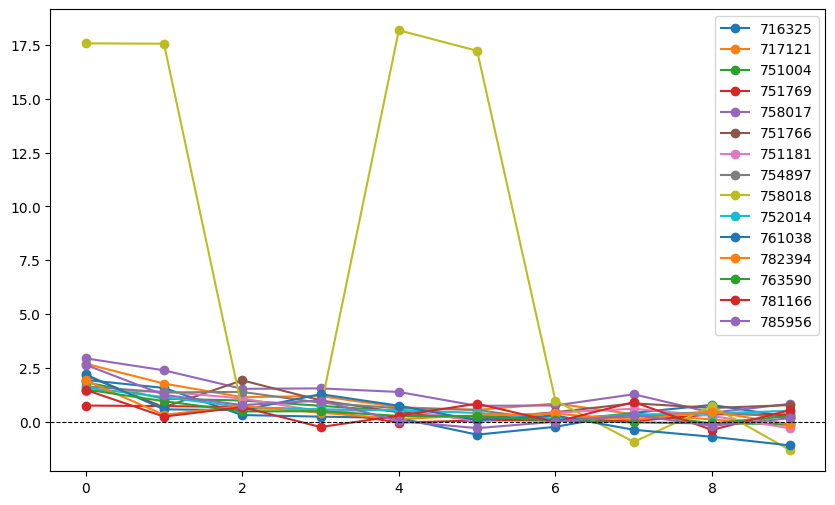

In [105]:
# plot the coefficients and CI
fig, ax = plt.subplots(figsize=(10, 6))
rwd_coeffs = all_results_df['rwd_coeffs'].values
rwd_CIs = all_results_df['rwd_CI'].values

for i in range(len(rwd_coeffs)):
    ax.plot(range(t_Max), rwd_coeffs[i], marker='o', label=f'{all_results_df["ani_id"].values[i]}')
    # ax.errorbar(range(3), rwd_coeffs[i], yerr=[rwd_coeffs[i] - rwd_CIs[i][:, 0], rwd_CIs[i][:, 1] - rwd_coeffs[i]], label='Reward Coefficients', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()

In [8]:
# regression model, use past rewards/no reward,  to predict future go/no-go
def hit_glm_all_trial(t_Max, t_Max_hist = 0):

    session_list_file = '/root/capsule/scratch/combined/combined_session_tbl/combined_beh_sessions.pkl'
    with open(session_list_file, 'rb') as f:
        combined_session_tbl = pickle.load(f)
    session_list = combined_session_tbl['session_id'].values
    combined_reg_df = pd.DataFrame()
    for session in session_list:
        session_tbl = get_session_tbl(session)

        hit = session_tbl['animal_response'].values != 2
        rewards = (session_tbl['rewarded_historyL'].values == 1) | (session_tbl['rewarded_historyR'].values == 1)
        # rewards[~hit] = np.nan  # only consider rewards when there is a hit
        choice = session_tbl['animal_response'].values
        pre_choice = np.full(len(choice), np.nan)
        pre_choice[1:] = choice[:-1]
        for i in range(1, len(choice)):
            if pre_choice[i] == 2:  # no-go
                last_choice = np.where(choice[:i] != 2)[0][-1] if np.any(choice[:i] != 2) else 0
                pre_choice[i] = choice[last_choice] if last_choice > 0 else np.nan

        hit_mtx = np.full((t_Max_hist, len(hit)), np.nan, dtype=float)
        for i in range(t_Max_hist):
            hit_mtx[i, i+1:] = hit[:(len(hit)-(i+1))]

        rwd_mtx = np.full((t_Max, len(hit)), np.nan, dtype=float)
        for i in range(t_Max):
            rwd_mtx[i, i+1:] = rewards[:(len(hit)-(i+1))]
        # create a DataFrame for regression
        col_list = [f'rwd_{i+1}' for i in range(t_Max)]
        pre_hist_list = [f'hit_{i+1}' for i in range(t_Max_hist)]
        col_list.extend(pre_hist_list)
        matrix = np.concatenate((rwd_mtx, hit_mtx), axis=0)
        reg_df = pd.DataFrame(matrix.T, columns=col_list)
        reg_df['hit'] = hit
        # reg_df['pre_choice'] = pre_choice
        # use statsmodels to fit a GLM
        # nan_df = df.DataFrame(np.full((len(reg_df), len(reg_df.columns)), np.nan), columns=reg_df.columns)
        combined_reg_df = pd.concat([combined_reg_df, reg_df], ignore_index=True)

    X = combined_reg_df.drop(columns=['hit']).values
    y = combined_reg_df['hit'].values
    X = sm.add_constant(X)  # add intercept term
    # nan mask to filter nan mask
    nan_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[nan_mask]
    y = y[nan_mask]
    model = sm.Logit(y, X)
    result = model.fit()
    # print(result.summary())

    rwd_coeffs = result.params[1:t_Max+1]
    hit_coeffs = result.params[t_Max+1:-1]
    # pre_choice_coeff = result.params[-1]
    rwd_CI = result.conf_int()[1:t_Max+1]
    hit_CI = result.conf_int()[t_Max+1:-1]

    # # plot coefficients
    # plt.figure(figsize=(10, 6))
    # plt.bar(range(t_Max), rwd_coeffs, label='Reward Coefficients', alpha=0.7)
    # plt.bar(range(t_Max, t_Max + t_Max_hist + 1), hit_coeffs, label='Hit Coefficients', alpha=0.7)
    # plt.bar(range(t_Max + t_Max_hist + 1, t_Max + t_Max_hist+2), pre_choice_coeff, label='Hit Coefficients', alpha=0.7)
    # plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    # plt.xlabel('Time Lag')
    # plt.ylabel('Coefficient Value')
    # plt.title('GLM Coefficients for Reward and Hit History')
    return {'rwd_coeffs': rwd_coeffs,
            'hit_coeffs': hit_coeffs,
            'rwd_CI': rwd_CI,
            'hit_CI': hit_CI}



In [9]:
tMax = 15
result = hit_glm_all_trial(tMax)

There is no nwb file in the raw directory.
Optimization terminated successfully.
         Current function value: 0.241112
         Iterations 8


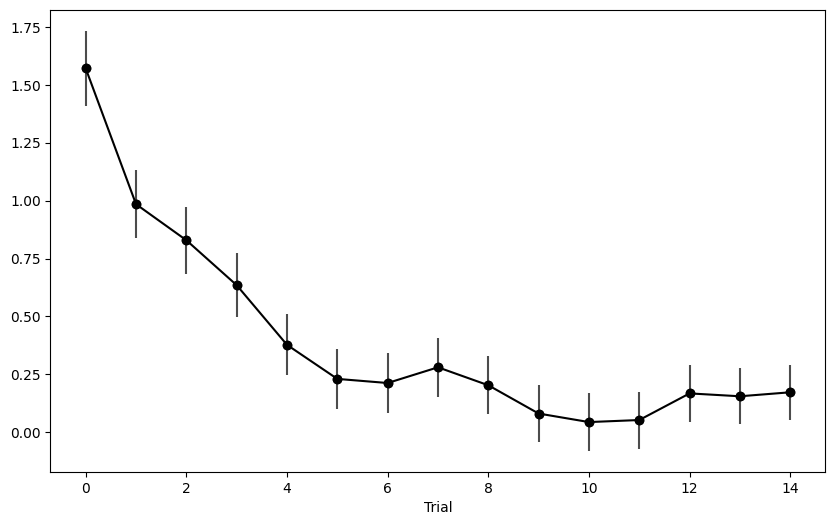

In [11]:
# plot results
rwd_coeffs = result['rwd_coeffs']
rwd_CI = result['rwd_CI']
hit_coeffs = result['hit_coeffs']
hit_CI = result['hit_CI']
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(tMax), rwd_coeffs, 'k', marker='o', label='Reward Coefficients', )
ax.errorbar(range(tMax), rwd_coeffs, yerr=[rwd_coeffs - rwd_CI[:, 0], rwd_CI[:, 1] - rwd_coeffs], fmt='o', alpha=0.7, c = 'k')
ax.set_xlabel('Trial')
plt.savefig(os.path.join('/root/capsule/scratch/combined/beh_plots', 'GLM_hit_reward_coefficients.pdf'), bbox_inches='tight')